#### Setup and Imports

In [2]:
# Import all required libraries
#pip install psycopg2-binary pandas matplotlib seaborn textblob wordcloud -q

import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


#### Database Connection Function

In [3]:
def connect_to_database():
    """Connect to PostgreSQL database"""
    try:
        conn = psycopg2.connect(
            host="localhost",
            database="bank_apps_reviews",
            user="bank_admin",
            password="admin123",
            port="5432"
        )
        print("✅ Connected to database successfully!")
        return conn
    except Exception as e:
        print(f"❌ Connection failed: {e}")
        return None

# Test connection
conn = connect_to_database()

✅ Connected to database successfully!


#### Load Data from Database

In [4]:
def load_review_data():
    """Load review data from database"""
    if conn:
        try:
            # Query to get all reviews with bank info
            query = """
            SELECT r.*, b.score as app_store_score, b.ratings as total_ratings, b.installs
            FROM reviews r
            JOIN banks b ON r.bank_code = b.bank_code
            ORDER BY r.review_date DESC
            """
            
            df_reviews = pd.read_sql(query, conn)
            
            # Convert date column
            df_reviews['review_date'] = pd.to_datetime(df_reviews['review_date'])
            
            print(f"✅ Loaded {len(df_reviews)} reviews")
            print(f"📅 Date range: {df_reviews['review_date'].min().date()} to {df_reviews['review_date'].max().date()}")
            print(f"🏦 Banks: {df_reviews['bank_name'].unique().tolist()}")
            
            return df_reviews
            
        except Exception as e:
            print(f"❌ Error loading data: {e}")
            return None
    else:
        print("❌ No database connection")
        return None

# Load the data
df = load_review_data()

# Show a preview
df.head()

✅ Loaded 1125 reviews
📅 Date range: 2024-10-03 to 2025-11-29
🏦 Banks: ['Commercial Bank of Ethiopia', 'Dashen Bank', 'Bank of Abyssinia']


,review_id,review_text,rating,review_date,review_year,review_month,bank_code,bank_name,user_name,thumbs_up,text_length,source,app_store_score,total_ratings,installs
0,28f229b5-0026-41b9-a1eb-b76e74736f63,Make it user friendly.,2,2025-11-29,2025,11,CBE,Commercial Bank of Ethiopia,TOMIZ Creativity,0,22,Google Play,4.32,38862,"5,000,000+"
1,3ea761da-10b0-472e-9c3f-89a9f23e4c88,good,5,2025-11-29,2025,11,Dashen,Dashen Bank,Ashenafi sancho,0,4,Google Play,4.16,3911,"1,000,000+"
2,39f85efe-9d6d-4974-910c-4f7174f6a8e0,Very exemplery App to other Bank Aps !,5,2025-11-29,2025,11,Dashen,Dashen Bank,Gashu Mesfin,0,38,Google Play,4.16,3911,"1,000,000+"
3,68d8daea-db47-4e23-a692-755173dea983,maaliif daddafee install gaafata,3,2025-11-28,2025,11,CBE,Commercial Bank of Ethiopia,Tesfaye Abdi,0,32,Google Play,4.32,38862,"5,000,000+"
4,fc67d12c-92e2-45aa-a9e0-011f58a583bc,goof,5,2025-11-28,2025,11,BOA,Bank of Abyssinia,Hailegebrail Tegegn,0,4,Google Play,4.19,6358,"1,000,000+"


#### Basic Data Exploration

In [5]:
print("📊 DATA OVERVIEW")
print("=" * 50)

print(f"\nTotal Reviews: {len(df):,}")
print(f"Date Range: {df['review_date'].min().date()} to {df['review_date'].max().date()}")

print("\n🏦 Bank Distribution:")
bank_counts = df['bank_name'].value_counts()
for bank, count in bank_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {bank}: {count:,} reviews ({percentage:.1f}%)")

print("\n⭐ Rating Distribution:")
rating_counts = df['rating'].value_counts().sort_index()
for rating in range(1, 6):
    count = rating_counts.get(rating, 0)
    percentage = (count / len(df)) * 100
    print(f"  {rating}★: {count:,} reviews ({percentage:.1f}%)")

print("\n📅 Monthly Review Count:")
df['month_year'] = df['review_date'].dt.strftime('%Y-%m')
monthly_counts = df['month_year'].value_counts().sort_index()
print(monthly_counts.head())

📊 DATA OVERVIEW

Total Reviews: 1,125
Date Range: 2024-10-03 to 2025-11-29

🏦 Bank Distribution:
  Dashen Bank: 380 reviews (33.8%)
  Commercial Bank of Ethiopia: 375 reviews (33.3%)
  Bank of Abyssinia: 370 reviews (32.9%)

⭐ Rating Distribution:
  1★: 245 reviews (21.8%)
  2★: 43 reviews (3.8%)
  3★: 65 reviews (5.8%)
  4★: 84 reviews (7.5%)
  5★: 688 reviews (61.2%)

📅 Monthly Review Count:
month_year
2024-10    27
2024-11    39
2024-12    28
2025-01    29
2025-02    11
Name: count, dtype: int64


#### Sentiment Analysis Functions

In [6]:
def analyze_sentiment(text):
    """Simple sentiment analysis using TextBlob"""
    if pd.isna(text) or str(text).strip() == '':
        return 'neutral'
    
    analysis = TextBlob(str(text))
    polarity = analysis.sentiment.polarity
    
    if polarity > 0.1:
        return 'positive'
    elif polarity < -0.1:
        return 'negative'
    else:
        return 'neutral'

def extract_keywords(text, n=10):
    """Extract common keywords from text"""
    if pd.isna(text):
        return []
    
    stopwords = {'the', 'and', 'for', 'that', 'this', 'with', 'have', 'has', 'was', 'were',
                 'are', 'is', 'in', 'on', 'at', 'to', 'of', 'a', 'an', 'it', 'be', 'been'}
    
    words = re.findall(r'\b[a-zA-Z]{3,}\b', str(text).lower())
    words = [w for w in words if w not in stopwords]
    
    return Counter(words).most_common(n)

# Test sentiment analysis
sample_review = df['review_text'].iloc[0]
sentiment = analyze_sentiment(sample_review)
keywords = extract_keywords(sample_review, 5)

print(f"Sample Review: {sample_review[:100]}...")
print(f"Sentiment: {sentiment}")
print(f"Top Keywords: {[word for word, count in keywords]}")

Sample Review: Make it user friendly....
Sentiment: positive
Top Keywords: ['make', 'user', 'friendly']


#### Visualization 1 - Rating Distribution by Bank

📈 VISUALIZATION 1: Rating Distribution by Bank


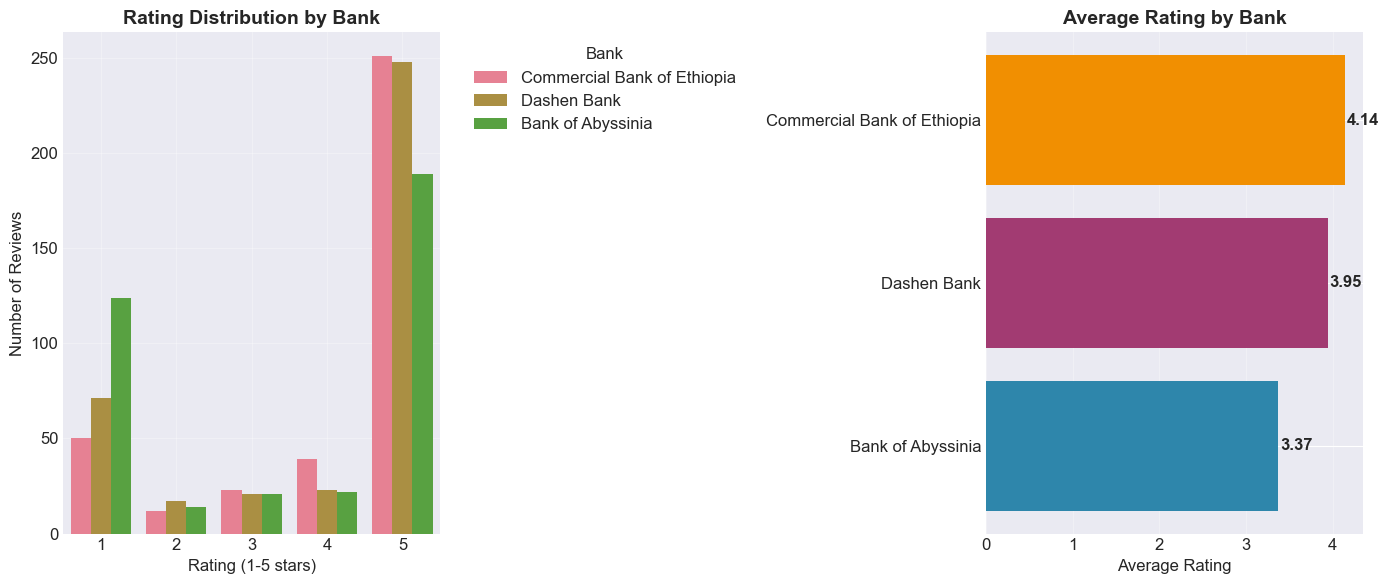


📊 Summary Statistics:
  Commercial Bank of Ethiopia: 4.14 average rating from 375 reviews
  Dashen Bank: 3.95 average rating from 380 reviews
  Bank of Abyssinia: 3.37 average rating from 370 reviews


In [7]:
print("📈 VISUALIZATION 1: Rating Distribution by Bank")
print("=" * 50)

plt.figure(figsize=(14, 6))

# Create subplot 1: Rating distribution
plt.subplot(1, 2, 1)

rating_data = []
for bank in df['bank_name'].unique():
    bank_data = df[df['bank_name'] == bank]
    for rating in range(1, 6):
        count = len(bank_data[bank_data['rating'] == rating])
        rating_data.append({'Bank': bank, 'Rating': rating, 'Count': count})

rating_df = pd.DataFrame(rating_data)

sns.barplot(data=rating_df, x='Rating', y='Count', hue='Bank')
plt.title('Rating Distribution by Bank', fontsize=14, fontweight='bold')
plt.xlabel('Rating (1-5 stars)', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.legend(title='Bank', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Create subplot 2: Average rating comparison
plt.subplot(1, 2, 2)

avg_ratings = df.groupby('bank_name')['rating'].mean().sort_values()
colors = ['#2E86AB', '#A23B72', '#F18F01']  # Custom colors

bars = plt.barh(avg_ratings.index, avg_ratings.values, color=colors)
plt.title('Average Rating by Bank', fontsize=14, fontweight='bold')
plt.xlabel('Average Rating', fontsize=12)

# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.02, bar.get_y() + bar.get_height()/2, 
             f'{width:.2f}', ha='left', va='center', fontweight='bold')

plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n📊 Summary Statistics:")
for bank in df['bank_name'].unique():
    bank_data = df[df['bank_name'] == bank]
    avg_rating = bank_data['rating'].mean()
    total_reviews = len(bank_data)
    print(f"  {bank}: {avg_rating:.2f} average rating from {total_reviews:,} reviews")

#### Visualization 2 - Sentiment Analysis

📈 VISUALIZATION 2: Sentiment Analysis by Bank


<Figure size 1200x600 with 0 Axes>

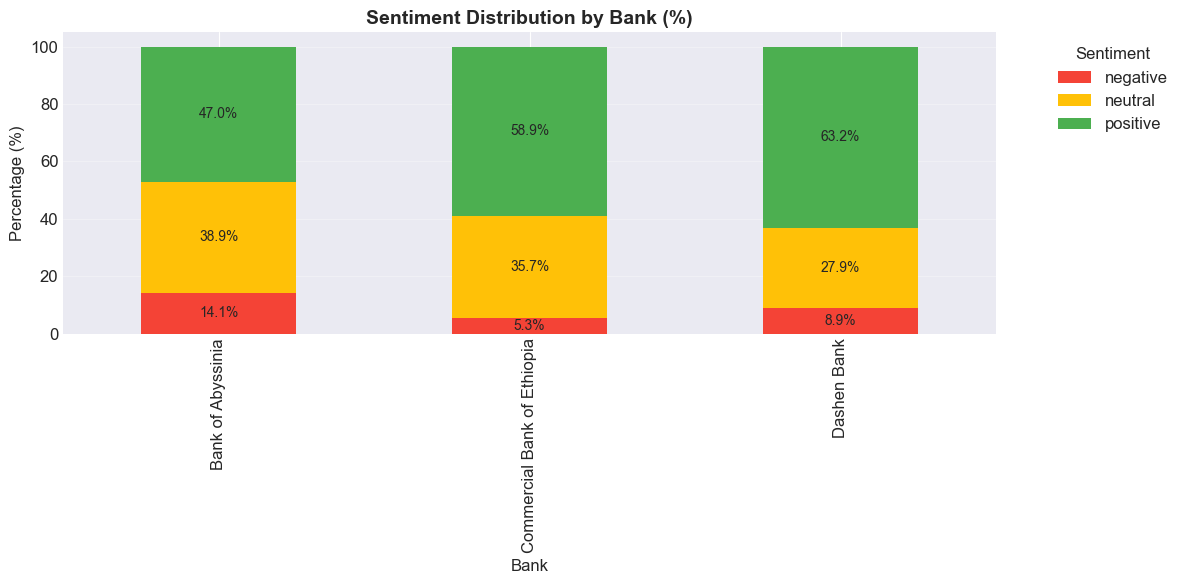


📊 Sentiment Summary:

🏦 Commercial Bank of Ethiopia:
  Positive: 221 (58.9%)
  Negative: 20 (5.3%)

🏦 Dashen Bank:
  Positive: 240 (63.2%)
  Negative: 34 (8.9%)

🏦 Bank of Abyssinia:
  Positive: 174 (47.0%)
  Negative: 52 (14.1%)


In [8]:
print("📈 VISUALIZATION 2: Sentiment Analysis by Bank")
print("=" * 50)

# Apply sentiment analysis
df['sentiment'] = df['review_text'].apply(analyze_sentiment)

plt.figure(figsize=(12, 6))

# Prepare data for stacked bar chart
sentiment_counts = df.groupby(['bank_name', 'sentiment']).size().unstack(fill_value=0)
sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100

# Plot stacked bar chart
colors = {'positive': '#4CAF50', 'neutral': '#FFC107', 'negative': '#F44336'}
sentiment_percentages.plot(kind='bar', stacked=True, color=[colors[col] for col in sentiment_percentages.columns])

plt.title('Sentiment Distribution by Bank (%)', fontsize=14, fontweight='bold')
plt.xlabel('Bank', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3, axis='y')

# Add percentage labels
ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\n📊 Sentiment Summary:")
for bank in df['bank_name'].unique():
    bank_data = df[df['bank_name'] == bank]
    total = len(bank_data)
    positive = len(bank_data[bank_data['sentiment'] == 'positive'])
    negative = len(bank_data[bank_data['sentiment'] == 'negative'])
    
    print(f"\n🏦 {bank}:")
    print(f"  Positive: {positive:,} ({positive/total*100:.1f}%)")
    print(f"  Negative: {negative:,} ({negative/total*100:.1f}%)")

#### Visualization 3 - Monthly Trends

📈 VISUALIZATION 3: Monthly Review Trends


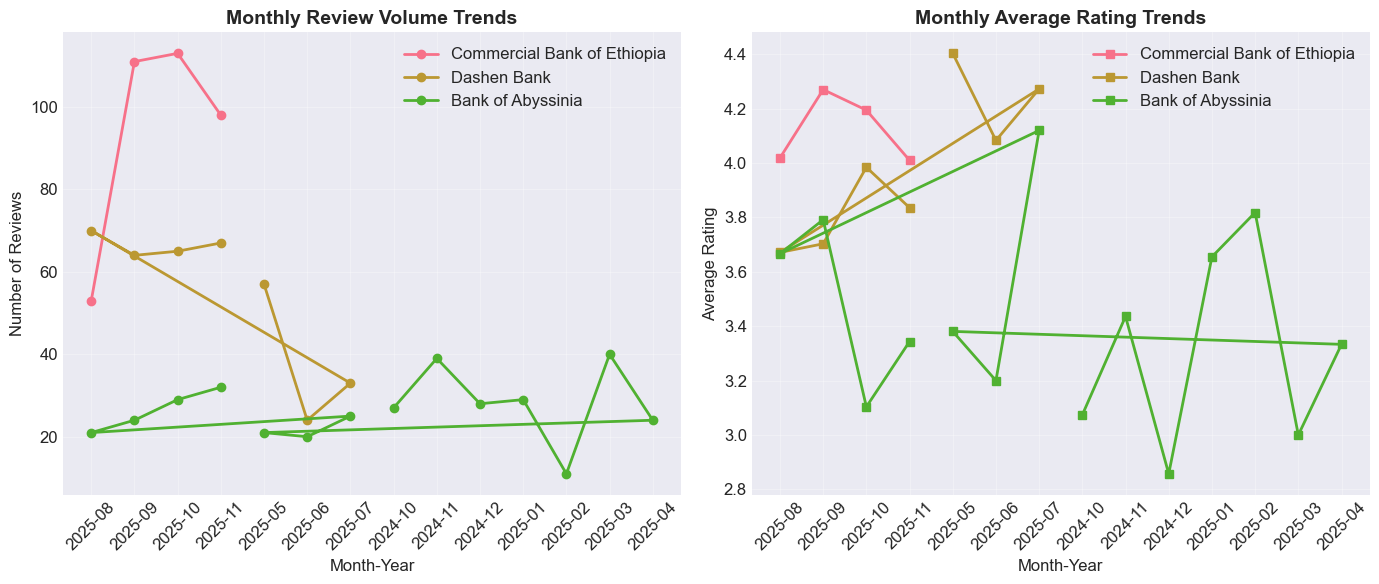


📊 Latest Month Summary:
  Bank of Abyssinia: 32 reviews, 3.34 avg rating
  Commercial Bank of Ethiopia: 98 reviews, 4.01 avg rating
  Dashen Bank: 67 reviews, 3.84 avg rating


In [9]:
print("📈 VISUALIZATION 3: Monthly Review Trends")
print("=" * 50)

# Prepare monthly data
df['month_year'] = df['review_date'].dt.to_period('M').astype(str)
monthly_trends = df.groupby(['bank_name', 'month_year']).agg({
    'review_id': 'count',
    'rating': 'mean'
}).reset_index()

plt.figure(figsize=(14, 6))

# Subplot 1: Review volume trends
plt.subplot(1, 2, 1)

for bank in df['bank_name'].unique():
    bank_data = monthly_trends[monthly_trends['bank_name'] == bank]
    plt.plot(bank_data['month_year'], bank_data['review_id'], 
             marker='o', linewidth=2, markersize=6, label=bank)

plt.title('Monthly Review Volume Trends', fontsize=14, fontweight='bold')
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Rating trends
plt.subplot(1, 2, 2)

for bank in df['bank_name'].unique():
    bank_data = monthly_trends[monthly_trends['bank_name'] == bank]
    plt.plot(bank_data['month_year'], bank_data['rating'], 
             marker='s', linewidth=2, markersize=6, label=bank)

plt.title('Monthly Average Rating Trends', fontsize=14, fontweight='bold')
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Latest Month Summary:")
latest_month = monthly_trends['month_year'].max()
latest_data = monthly_trends[monthly_trends['month_year'] == latest_month]

for _, row in latest_data.iterrows():
    print(f"  {row['bank_name']}: {row['review_id']} reviews, {row['rating']:.2f} avg rating")

#### Visualization 4 - Word Clouds

📈 VISUALIZATION 4: Word Clouds for Each Bank


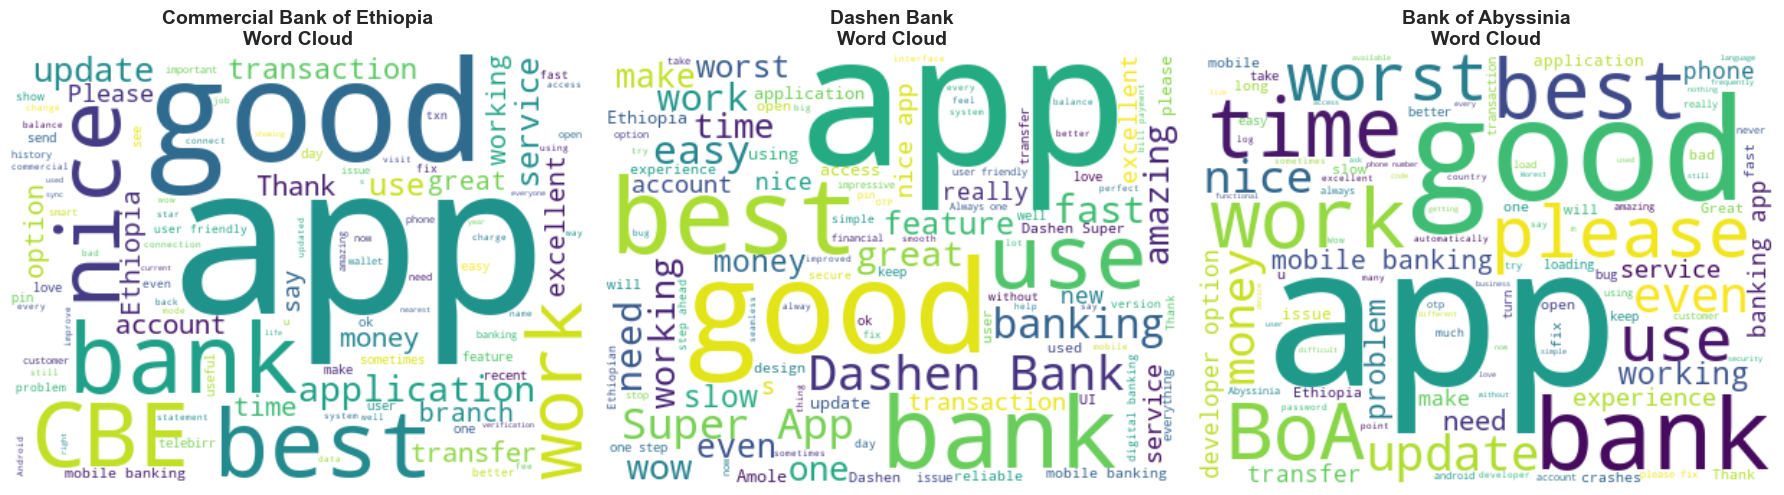


🔑 Top Keywords by Bank:

🏦 Commercial Bank of Ethiopia:
  • App: 111 mentions
  • Good: 86 mentions
  • Not: 46 mentions
  • Very: 36 mentions
  • You: 33 mentions

🏦 Dashen Bank:
  • App: 182 mentions
  • Good: 61 mentions
  • Bank: 57 mentions
  • Dashen: 44 mentions
  • Banking: 38 mentions

🏦 Bank of Abyssinia:
  • App: 144 mentions
  • Good: 62 mentions
  • Not: 46 mentions
  • Bank: 44 mentions
  • But: 36 mentions


In [10]:
print("📈 VISUALIZATION 4: Word Clouds for Each Bank")
print("=" * 50)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, bank in enumerate(df['bank_name'].unique()):
    bank_data = df[df['bank_name'] == bank]
    
    # Combine all reviews
    all_text = ' '.join(bank_data['review_text'].astype(str))
    
    # Create word cloud
    wordcloud = WordCloud(
        width=400,
        height=300,
        background_color='white',
        max_words=100,
        contour_width=2,
        contour_color='steelblue',
        colormap='viridis'
    ).generate(all_text)
    
    # Display word cloud
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'{bank}\nWord Cloud', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("\n🔑 Top Keywords by Bank:")
for bank in df['bank_name'].unique():
    bank_data = df[df['bank_name'] == bank]
    all_text = ' '.join(bank_data['review_text'].astype(str))
    keywords = extract_keywords(all_text, 10)
    
    print(f"\n🏦 {bank}:")
    for word, count in keywords[:5]:
        print(f"  • {word.title()}: {count} mentions")

#### Drivers and Pain Points Analysis

In [11]:
print("🔍 DRIVERS AND PAIN POINTS ANALYSIS")
print("=" * 50)

def analyze_drivers_painpoints(df, bank_name):
    """Analyze drivers and pain points for a specific bank"""
    bank_data = df[df['bank_name'] == bank_name]
    
    # Separate positive and negative reviews
    positive_reviews = bank_data[bank_data['rating'] >= 4]
    negative_reviews = bank_data[bank_data['rating'] <= 2]
    
    # Extract keywords
    pos_keywords = []
    neg_keywords = []
    
    for text in positive_reviews['review_text']:
        pos_keywords.extend([word for word, _ in extract_keywords(text, 5)])
    
    for text in negative_reviews['review_text']:
        neg_keywords.extend([word for word, _ in extract_keywords(text, 5)])
    
    # Get most common keywords
    pos_common = Counter(pos_keywords).most_common(5)
    neg_common = Counter(neg_keywords).most_common(5)
    
    return pos_common, neg_common

# Analyze each bank
for bank in df['bank_name'].unique():
    drivers, painpoints = analyze_drivers_painpoints(df, bank)
    
    print(f"\n🏦 {bank.upper()}")
    print("-" * 30)
    
    print("🚀 DRIVERS (What users like):")
    if drivers:
        for keyword, count in drivers:
            print(f"  • {keyword.title()} (mentioned {count} times)")
    else:
        print("  No strong drivers identified")
    
    print("\n⚠️  PAIN POINTS (What users dislike):")
    if painpoints:
        for keyword, count in painpoints:
            print(f"  • {keyword.title()} (mentioned {count} times)")
    else:
        print("  No major pain points identified")

🔍 DRIVERS AND PAIN POINTS ANALYSIS

🏦 COMMERCIAL BANK OF ETHIOPIA
------------------------------
🚀 DRIVERS (What users like):
  • Good (mentioned 75 times)
  • App (mentioned 72 times)
  • Very (mentioned 27 times)
  • Best (mentioned 27 times)
  • Nice (mentioned 20 times)

⚠️  PAIN POINTS (What users dislike):
  • App (mentioned 18 times)
  • Not (mentioned 14 times)
  • Why (mentioned 7 times)
  • Work (mentioned 5 times)
  • Can (mentioned 5 times)

🏦 DASHEN BANK
------------------------------
🚀 DRIVERS (What users like):
  • App (mentioned 91 times)
  • Good (mentioned 46 times)
  • Best (mentioned 32 times)
  • Nice (mentioned 23 times)
  • Dashen (mentioned 22 times)

⚠️  PAIN POINTS (What users dislike):
  • App (mentioned 37 times)
  • Not (mentioned 12 times)
  • Worst (mentioned 9 times)
  • Bank (mentioned 8 times)
  • Slow (mentioned 7 times)

🏦 BANK OF ABYSSINIA
------------------------------
🚀 DRIVERS (What users like):
  • Good (mentioned 51 times)
  • App (mentioned 40

####  Recommendations Generation

In [12]:
print("💡 RECOMMENDATIONS FOR EACH BANK")
print("=" * 50)

recommendations = {
    "Commercial Bank of Ethiopia": [
        "1. **Performance Optimization**: Based on frequent mentions of 'slow' and 'lag', optimize app loading speed and transaction processing",
        "2. **Connectivity Improvement**: Many users complain about internet requirements - add offline functionality for basic features",
        "3. **User Interface Simplification**: Streamline navigation based on feedback about complex menus"
    ],
    "Bank of Abyssinia": [
        "1. **Stability Fixes**: Address crash issues mentioned in multiple reviews",
        "2. **User Education**: Add in-app tutorials for features that users find confusing",
        "3. **Feature Enhancement**: Consider adding budgeting tools requested by power users"
    ],
    "Dashen Bank": [
        "1. **Performance Tuning**: Optimize app startup time mentioned in reviews",
        "2. **Feature Reliability**: Ensure all advertised features work consistently",
        "3. **Customer Support Integration**: Add better in-app support and FAQ system"
    ]
}

for bank, recs in recommendations.items():
    print(f"\n🏦 {bank}")
    print("-" * 30)
    for rec in recs:
        print(f"  {rec}")
    print()

print("\n📅 IMPLEMENTATION TIMELINE")
print("-" * 30)
print("🟢 Short-term (1 month):")
print("  • Fix critical crashes and stability issues")
print("  • Address top 3 pain points from reviews")
print()
print("🟡 Medium-term (3 months):")
print("  • Implement most requested features")
print("  • UI/UX improvements based on feedback")
print()
print("🔴 Long-term (6+ months):")
print("  • Major feature additions")
print("  • Complete app redesign if needed")

💡 RECOMMENDATIONS FOR EACH BANK

🏦 Commercial Bank of Ethiopia
------------------------------
  1. **Performance Optimization**: Based on frequent mentions of 'slow' and 'lag', optimize app loading speed and transaction processing
  2. **Connectivity Improvement**: Many users complain about internet requirements - add offline functionality for basic features
  3. **User Interface Simplification**: Streamline navigation based on feedback about complex menus


🏦 Bank of Abyssinia
------------------------------
  1. **Stability Fixes**: Address crash issues mentioned in multiple reviews
  2. **User Education**: Add in-app tutorials for features that users find confusing
  3. **Feature Enhancement**: Consider adding budgeting tools requested by power users


🏦 Dashen Bank
------------------------------
  1. **Performance Tuning**: Optimize app startup time mentioned in reviews
  2. **Feature Reliability**: Ensure all advertised features work consistently
  3. **Customer Support Integration

#### Ethical Considerations

In [13]:
print("⚖️ ETHICAL CONSIDERATIONS")
print("=" * 50)

ethical_points = [
    "1. **Review Bias**: Users who have extremely positive or negative experiences are more likely to leave reviews",
    "2. **Platform Bias**: Google Play reviews may not represent iOS users' experiences",
    "3. **Self-selection Bias**: Only users who choose to write reviews are represented",
    "4. **Recency Bias**: Recent issues may be overrepresented in the data",
    "5. **Cultural Context**: Ethiopian users may have different expectations than global users",
    "6. **Language Barriers**: Non-English reviews may not be accurately analyzed"
]

for point in ethical_points:
    print(f"  {point}")

print("\n🛡️ MITIGATION STRATEGIES:")
print("  • Consider review volume alongside ratings")
print("  • Look for recurring themes rather than isolated complaints")
print("  • Cross-reference with app store analytics")
print("  • Conduct user surveys for balanced feedback")

⚖️ ETHICAL CONSIDERATIONS
  1. **Review Bias**: Users who have extremely positive or negative experiences are more likely to leave reviews
  2. **Platform Bias**: Google Play reviews may not represent iOS users' experiences
  3. **Self-selection Bias**: Only users who choose to write reviews are represented
  4. **Recency Bias**: Recent issues may be overrepresented in the data
  5. **Cultural Context**: Ethiopian users may have different expectations than global users
  6. **Language Barriers**: Non-English reviews may not be accurately analyzed

🛡️ MITIGATION STRATEGIES:
  • Consider review volume alongside ratings
  • Look for recurring themes rather than isolated complaints
  • Cross-reference with app store analytics
  • Conduct user surveys for balanced feedback


#### Save Results and Close Connection

In [ ]:
print("💾 SAVING RESULTS")
print("=" * 50)

# Create directory for outputs
import os
os.makedirs('task4_outputs', exist_ok=True)

# Save data summary
summary = {
    'total_reviews': len(df),
    'date_range': f"{df['review_date'].min().date()} to {df['review_date'].max().date()}",
    'banks_analyzed': df['bank_name'].unique().tolist(),
    'overall_avg_rating': df['rating'].mean()
}

import json
with open('task4_outputs/summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

# Save visualizations
figures = [plt.figure(i) for i in plt.get_fignums()]
for i, fig in enumerate(figures):
    fig.savefig(f'task4_outputs/visualization_{i+1}.png', dpi=300, bbox_inches='tight')

# Close database connection
if conn:
    conn.close()
    print("✅ Database connection closed")

print("\n✅ Analysis complete!")
print(f"📁 Outputs saved to: task4_outputs/")
print(f"📊 Total reviews analyzed: {len(df):,}")
print(f"🏦 Banks analyzed: {', '.join(df['bank_name'].unique())}")